# Quick start
 
For example, we  use the spatial expression matrix of Bin1 of Stereo-Seq in the mouse olfactory bulb for the use of **stereopy** tools for downstream analysis.

The format of the original expression matrix of Bin1 is as follows: x, y are the spatial position of the gene in the tissue section, and count is the number of gene expression.

|  GeneID   | x | y | count |
|  ----  | ----  | ----| ----|
| Gene1  | 121 | 200 | 2 |
| Gene2  | 234 | 300 | 1 |
| ...  | ... | ... | ... |
| Gene n | 234 | 300 | 1 |



## Read the raw data of Stereo-Seq

The resolution of Stereo-Seq sequencing technology is up to nanometer level. The nanopore radius of Bin1 is 250 nm. 

Generally, the **bin_size** parameter is set to combine the nanopores within a certain range into a bin unit for analysis. tthe side length of the bin unit is approximately 14 microns when **bin_size** is set to 20.

After merging according to a certain **bin_size**, we will uniformly generate the data into the format of AnnData for downstream analysis. For details of AnnData, see
*https://scanpy.readthedocs.io/en/latest/usage-principles.html#anndata*

In addition, stereopy can support reading 10x data, as detailed in the API documentation.

In [1]:
import warnings

warnings.filterwarnings('ignore')
import stereo as st


In [ ]:
!mkdir stereo_demo
!cd stereo_demo
!git clone https://github.com/BGIResearch/stereopy_data.git
!cd stereopy_data/mouse

In [2]:
mouse_data_path = './DP8400013846TR_F5.gem'
andata = st.io.read_stereo_data(mouse_data_path, bin_size=100)

2021-05-31 15:06:33 Spateo INFO: the martrix has 3347 bins, and 28553 genes.
2021-05-31 15:06:38 Spateo INFO: the size of matrix is 4.470348358154297e-08 G.


In [3]:
andata.raw = andata

## Preprocessing

Data preprocessing includes three modules: **Quality control**, **Filtering** and **Normalization**.

### Quality control

The quality control module mainly calculates the data quality distribution of the original data, and mainly counts three indicators:
- the number of genes expressed in the count matrix. (n_genes_by_counts)
- the total counts per cell. (total_counts)
- the percentage of counts in mitochondrial genes. (pct_counts_mt)

In [4]:
andata = st.preprocess.cal_qc(andata=andata)

Show the violin figure of the qc distribution.

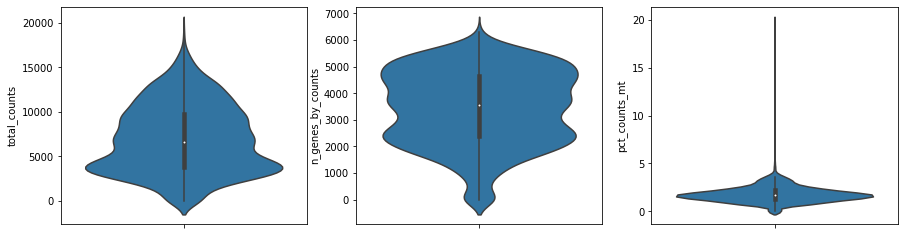

In [5]:
st.plt.plot_violin_distribution(andata)

Show the spatial scatter figure of the qc distribution.

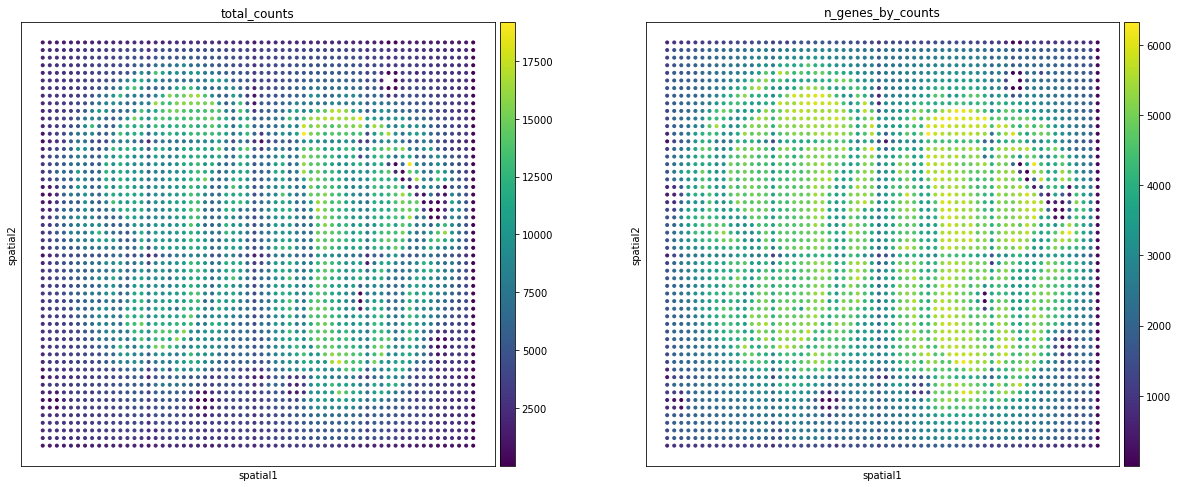

In [6]:
st.plt.plot_spatial_distribution(andata)

### Filtering

Generally, we will filter the `bin unit` based on the three quality control indicators total_count, n_genes_by_counts and pct_counts_MT.

In [7]:
st.preprocess.filter_cells(adata=andata, min_gene=200, n_genes_by_counts=3, pct_counts_mt=5, inplace=True)

In addition, we also provide `st.preprocess.filter_genes` function to filter genes and `st.preprocess.filter_coordinates` function to filer bin unit by its coordinate.

For detailed instructions, please refer to its api document.

### Normalization

In this module, we mainly provide three common standardization methods.

- normalize_total
- quantile
- zscore_disksmooth

If the parameter `inplace` is set to True, andata.X will be replaced with the normalized result, otherwise unchanged.

In [10]:
normalizer = st.preprocess.Normalizer(data=andata, method='normalize_total', inplace=False, target_sum=10000, name='normalize_total')
nor_total = normalizer.fit()
print(nor_total)

[[0.         0.         5.448404   ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.0391517 ]
 [6.323777   0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.86565095]
 [0.         0.         0.         ... 0.         0.         6.405124  ]]


In [11]:
normalizer = st.preprocess.Normalizer(data=andata, method='quantile', inplace=False, name='quantile_nor')
nor_quantile = normalizer.fit()
print(nor_quantile)

[[0.        0.        4.005194  ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        1.4314085]
 [3.710663  0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.5062634]
 [0.        0.        0.        ... 0.        0.        4.4854875]]


In [12]:
normalizer = st.preprocess.Normalizer(data=andata, method='zscore_disksmooth', inplace=False, r=20, name='zscore_disksmooth')
nor_zscore_disksmooth = normalizer.fit()
print(nor_zscore_disksmooth)

[[0.8220383 0.8220383 3.9170845 ... 0.8220383 0.8220383 0.8220383]
 [0.8265274 0.8265274 0.8265274 ... 0.8265274 0.8265274 2.1132417]
 [2.954915  0.8289777 0.8289777 ... 0.8289777 0.8289777 0.8289777]
 ...
 [0.825772  0.825772  0.825772  ... 0.825772  0.825772  0.825772 ]
 [0.8321754 0.8321754 0.8321754 ... 0.8321754 0.8321754 1.5398376]
 [0.8300709 0.8300709 0.8300709 ... 0.8300709 0.8300709 3.4370248]]


## Dimensionality reduction

By default, PCA is used to reduce dimensionality. 

In addition, it supports `tsen`, `umap`, `factor analysis`, `low variance` and other dimensionality reduction methods.See the API related documentation for details.

In [14]:
# Using the zscore_disksmooth normalization data for dimensionality reduction. 
andata.X = nor_zscore_disksmooth
dim_reduce = st.tools.DimReduce(data=andata, method='pca', n_pcs=30, min_variance=0.01, n_iter=250, n_neighbors=20, min_dist=0.3, inplace=False, name='dim_reduce')
dim_reduce.fit()

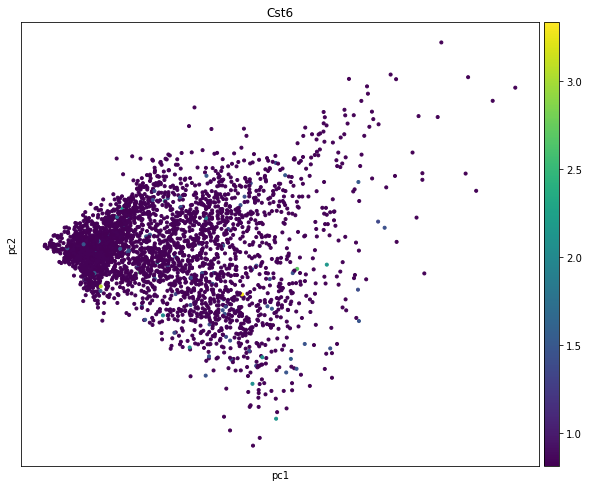

In [15]:
st.plt.plot_dim_reduce(andata, plot_key=['Cst6'])

## Clustering

Currently we provide two common clustering methods, including leiden and louvain. 

In this tool, you can re-run the normalization method before clustering if the `normalize_method` parameter is not None. Then by default, we use pca to reduce the dimensionality of the new normalization method, and then using the top 30 pcs to run clustering.

In [16]:
cluster = st.tools.Clustering(data=andata, method='leiden', dim_reduce_key='dim_reduce',n_neighbors=30, name='clustering')
cluster.fit()

Show the spatial distribution of the clusering result.

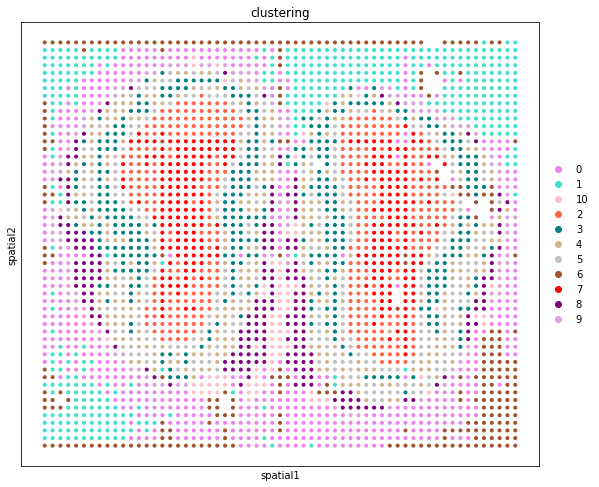

In [18]:
st.plots.plot_spatial_cluster(adata=andata, cluster_names=['clustering'], pos_key='spatial')

It can also show the dimensionality reduction spatial distribution of the clustering result if the `pos_key` is set to be dimensionality reduction tool's name.

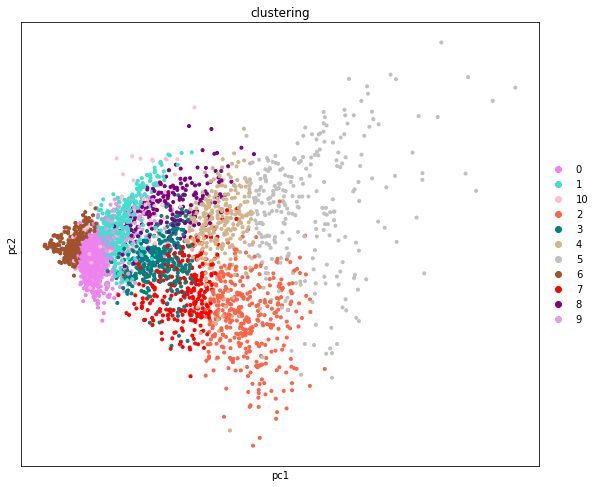

In [19]:
st.plots.plot_spatial_cluster(adata=andata, cluster_names=['clustering'], pos_key='dim_reduce')

## Find marker genes

By default, the `.X` attribute of AnnData is used to compute the result. We support two tools to find marker genes, including `st.tools.FindMarker` and `st.tools.SpatialLag`.

### Hypothesis test
In `st.tools.FindMarker`, it provides a hypothesis test to analyze differences between two groups. It support two methods including `t-test` and `wicoxon`.

In [20]:
andata.X = andata.raw.X
marker = st.tools.FindMarker(data=andata, cluster='clustering', corr_method='bonferroni', method='t-test', name='marker_test')
marker.fit()

Find marker gene: 100%|██████████| 11/11 [00:40<00:00,  3.65s/it]


Then, show the score of top 10 marker genes for the each group.

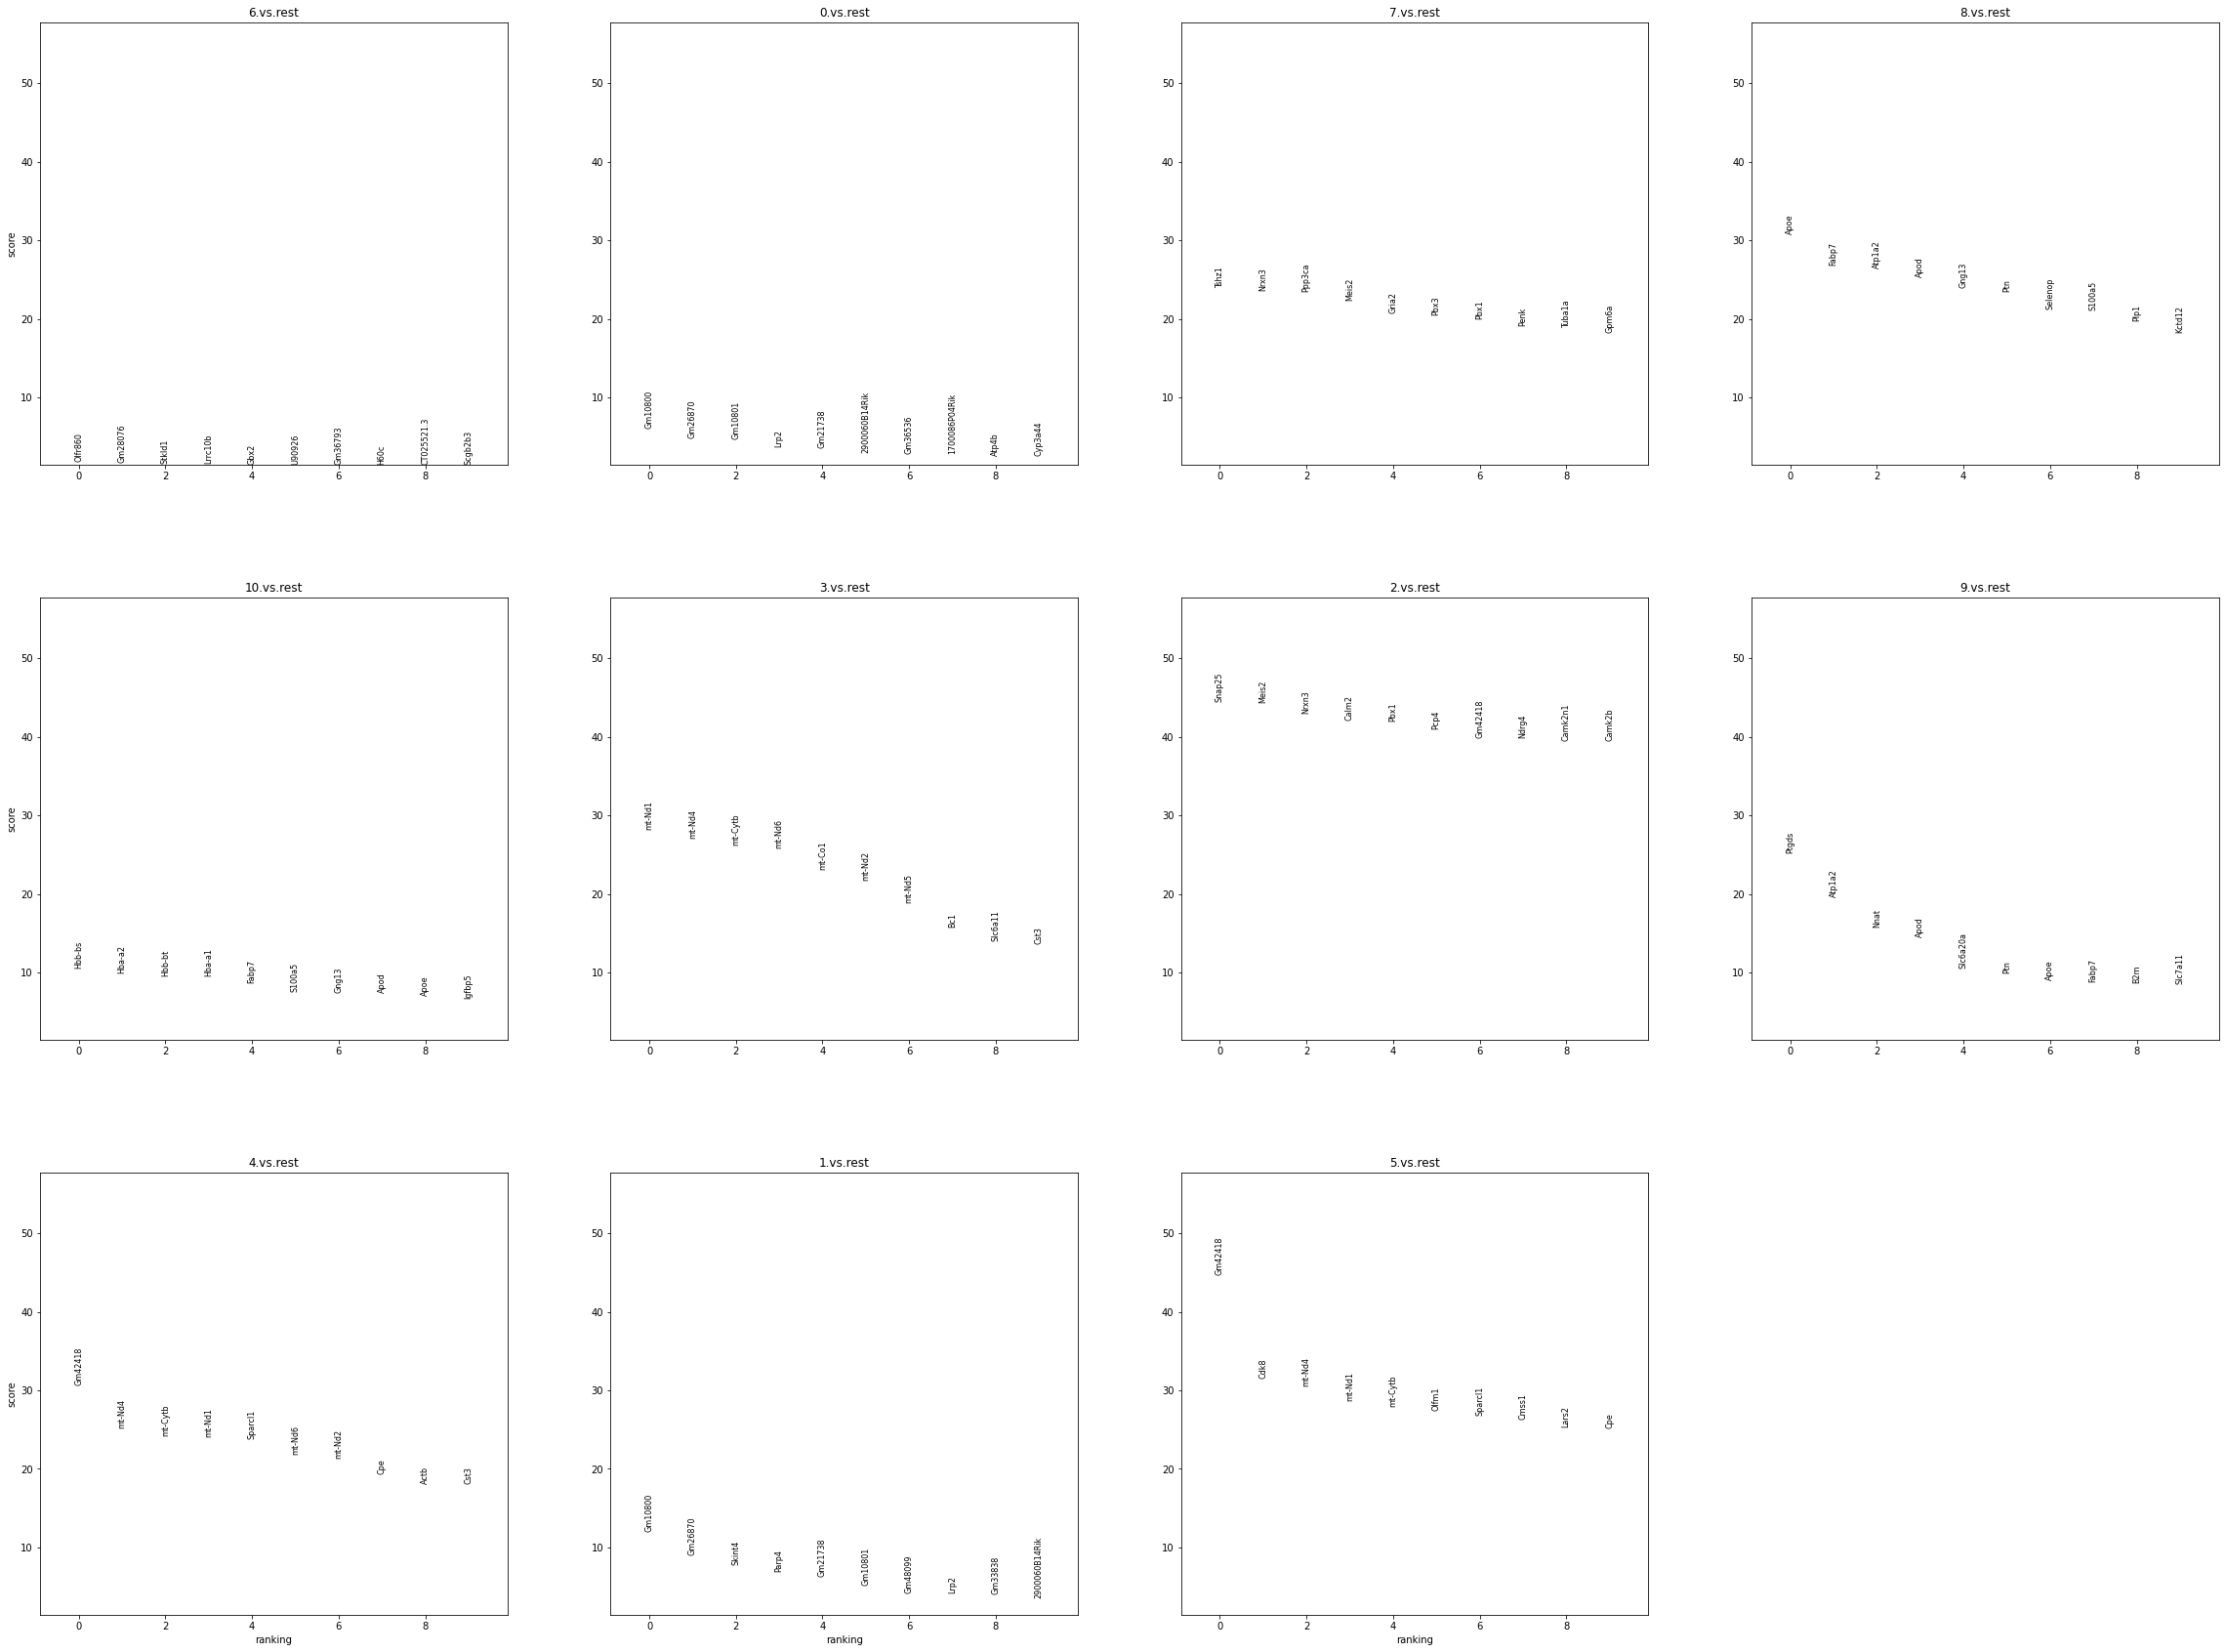

In [21]:
st.plt.plot_marker_genes(adata=andata, n_genes=10, find_maker_name='marker_test')

In [22]:
andata.uns['marker_test']['1.vs.rest'].top_k_marker(top_k_genes=10, ascend=False, sort_key='scores')

genes     scores       pvalues   pvalues_adj    log2fc
14918        Gm10800  11.958448  3.366396e-29  9.612070e-25  4.323322
27565        Gm26870   9.074567  2.972018e-18  8.486004e-14  1.747631
14205         Skint4   7.821376  3.229831e-14  9.222137e-10  1.789073
19096          Parp4   6.948864  1.107303e-11  3.161682e-07  1.447583
11705        Gm21738   6.275651  7.500449e-10  2.141603e-05  1.472252
5125         Gm10801   5.158772  3.513841e-07  1.003307e-02  1.445109
16591        Gm48099   4.236125  2.678162e-05  7.646955e-01  2.095825
22241           Lrp2   4.164337  3.683378e-05  1.000000e+00  1.645840
20153        Gm33838   4.010643  6.969560e-05  1.000000e+00  2.056288
27801  2900060B14Rik   3.559098  4.103440e-04  1.000000e+00  4.416056

Show the heatmap plot of top 10 marker genes.

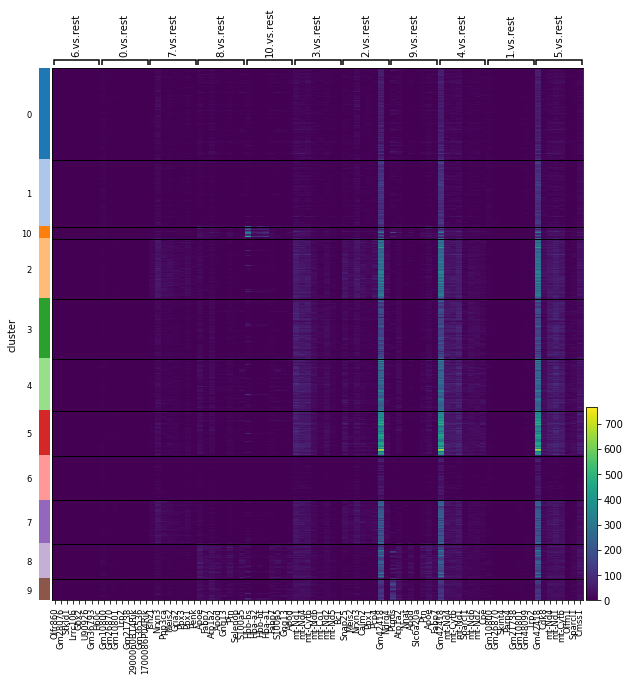

In [23]:
st.plt.plot_heatmap_marker_genes(adata=andata, cluster_name='clustering', fine_maker_name='marker_test', num_show_gene=8)

### spatial lag model

By default, the tool calculate all genes's lag coefficient, which takes some time. 

If you only want to see the genes you are interested in, you can set the genes through the parameter `gene` .

In [3]:
lag = st.tools.SpatialLag(data=andata, cluster='clustering')
lag.fit()

performing GM_lag_model and assign coefficient and p-val to cell type: 28553it [1:13:37,  6.46it/s]


SpatialLagResult of spatial_lag. 
  params: {'data': AnnData object with n_obs × n_vars = 3273 × 28553
    obs: 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'clustering'
    var: 'E10', 'pattern_attribute'
    uns: 'dim_reduce', 'clustering', 'marker_test', 'spatial_pattern_score', 'spatial_lag'
    obsm: 'spatial', 'method': 'gm_lag', 'name': 'spatial_lag', 'cluster': 'clustering', 'genes': None, 'random_drop': True, 'drop_dummy': None, 'n_neighbors': 8}
    result: a DataFrame which has `genes`,`lag_coeff`, `lag_zstat`, `lag_pval` columns.
    the shape is: (28553, 39)

Show the result of spatial lag model.

In [4]:
andata.uns['spatial_lag'].score

const_lag_coeff const_lag_zstat const_lag_pval 6_lag_coeff  \
Usp25               0.0        8.946687            0.0        -0.0   
Nsun4               0.0        4.132865       0.000036        -0.0   
Ankrd27             0.0        14.56792            0.0        -0.0   
Snx16              -0.0       -8.106615            0.0        -0.0   
Dnajc11             0.0       12.959548            0.0        -0.0   
...                 ...             ...            ...         ...   
Olfr901             0.0          5.0793            0.0         0.0   
Rhof                0.0       12.336037            0.0        -0.0   
Mymx               -0.0       -2.717234       0.006583         0.0   
Gm4961              0.0             0.0            1.0         0.0   
Tmem88b             0.0        6.916419            0.0        -0.0   

        6_lag_zstat 6_lag_pval 10_lag_coeff 10_lag_zstat 10_lag_pval  \
Usp25     -1.089746   0.275825         -0.0   -17.773908         0.0   
Nsun4    -13.552861        0.0         -0.0    -5.692202         0.0   
Ankrd27  -14.659009        0.0         -0.0   -21.833229         0.0   
Snx16     -0.622912   0.533343          0.0    10.344581         0.0   
Dnajc11   -2.257633   0.023969          0.0      1.93806    0.052616   
...             ...        ...          ...          ...         ...   
Olfr901    2.378771    0.01737          0.0          0.0         1.0   
Rhof      -5.227498        0.0         -0.0    -5.584313         0.0   
Mymx      15.273237        0.0          0.0     7.473224         0.0   
Gm4961          0.0        1.0          0.0          0.0         1.0   
Tmem88b  -11.246806        0.0         -0.0   -14.020374         0.0   

        5_lag_coeff  ... 9_lag_pval 1_lag_coeff 1_lag_zstat 1_lag_pval  \
Usp25          -0.0  ...        0.0        -0.0   -3.870143   0.000109   
Nsun4          -0.0  ...   0.000098        -0.0   -8.796493        0.0   
Ankrd27        -0.0  ...        0.0        -0.0   -8.042222        0.0   
Snx16           0.0  ...   0.001362         0.0   10.671248        0.0   
Dnajc11        -0.0  ...        0.0        -0.0  -18.139548        0.0   
...             ...  ...        ...         ...         ...        ...   
Olfr901         0.0  ...        0.0        -0.0    -4.34646   0.000014   
Rhof           -0.0  ...   0.848027        -0.0   -6.572743        0.0   
Mymx            0.0  ...   0.000002         0.0    4.654886   0.000003   
Gm4961          0.0  ...        0.0         0.0         0.0        1.0   
Tmem88b        -0.0  ...   0.000003        -0.0    -8.50945        0.0   

        2_lag_coeff 2_lag_zstat 2_lag_pval W_log_exp_lag_coeff  \
Usp25          -0.0  -13.026843        0.0                 1.0   
Nsun4          -0.0   -10.10921        0.0                 1.0   
Ankrd27        -0.0   -9.744015        0.0                 1.0   
Snx16          -0.0   -3.052325   0.002271                 1.0   
Dnajc11        -0.0   -5.485358        0.0                 1.0   
...             ...         ...        ...                 ...   
Olfr901        -0.0   -2.009474   0.044487                 1.0   
Rhof           -0.0   -5.529261        0.0                 1.0   
Mymx            0.0    8.601905        0.0                 1.0   
Gm4961          0.0    4.222483   0.000024                 1.0   
Tmem88b        -0.0  -15.034559        0.0                 1.0   

          W_log_exp_lag_zstat W_log_exp_lag_pval  
Usp25     10635157767146558.0                0.0  
Nsun4     22200843911600024.0                0.0  
Ankrd27   19047907335290980.0                0.0  
Snx16     13521305187714484.0                0.0  
Dnajc11    8693019356478832.0                0.0  
...                       ...                ...  
Olfr901  117655992856589232.0                0.0  
Rhof      11756243140250622.0                0.0  
Mymx     154417290989220000.0                0.0  
Gm4961   123678660952112016.0                0.0  
Tmem88b   16331137147464286.0                0.0  

[28553 

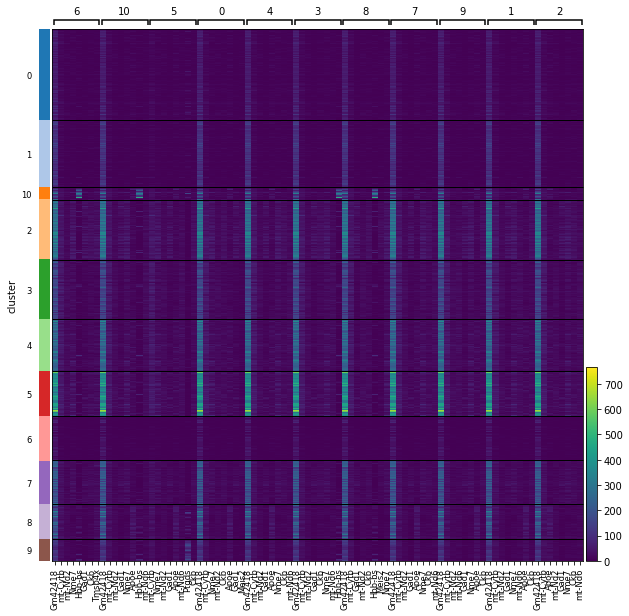

In [5]:
st.plt.plot_heatmap_marker_genes(adata=andata, cluster_name='clustering', fine_maker_name='spatial_lag', num_show_gene=8)

## spatial pattern score

The analysis is to calculate the spatial pattern score of the genes. The higher the score, the more specific expression pattern of the gene in space.

In [2]:
sps = st.tools.SpatialPatternScore(data=andata, name='spatial_pattern_score')
sps.fit()

cal the enrichment score...: 100%|██████████| 28553/28553 [45:56<00:00, 10.36it/s]  


In [12]:
pattern_genes = andata.uns['spatial_pattern_score'].spatial_pattern_score[andata.uns['spatial_pattern_score'].spatial_pattern_score['attribute'] == 'pattern']
pattern_genes.head(10)

gene    E10 attribute
Gria3      Gria3  28.07   pattern
Lrp12      Lrp12  25.79   pattern
Nap1l5    Nap1l5  28.92   pattern
Dlx1        Dlx1  27.16   pattern
Ywhaz      Ywhaz  27.03   pattern
Aak1        Aak1  25.82   pattern
Cox6c      Cox6c  25.86   pattern
Mgp          Mgp  36.31   pattern
Smarcd1  Smarcd1  28.50   pattern
Cacna1c  Cacna1c  28.67   pattern

Show the top 10 genes.

/data/workspace/st/stereopy-release/stereo/plots/scatter.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(bad_color)


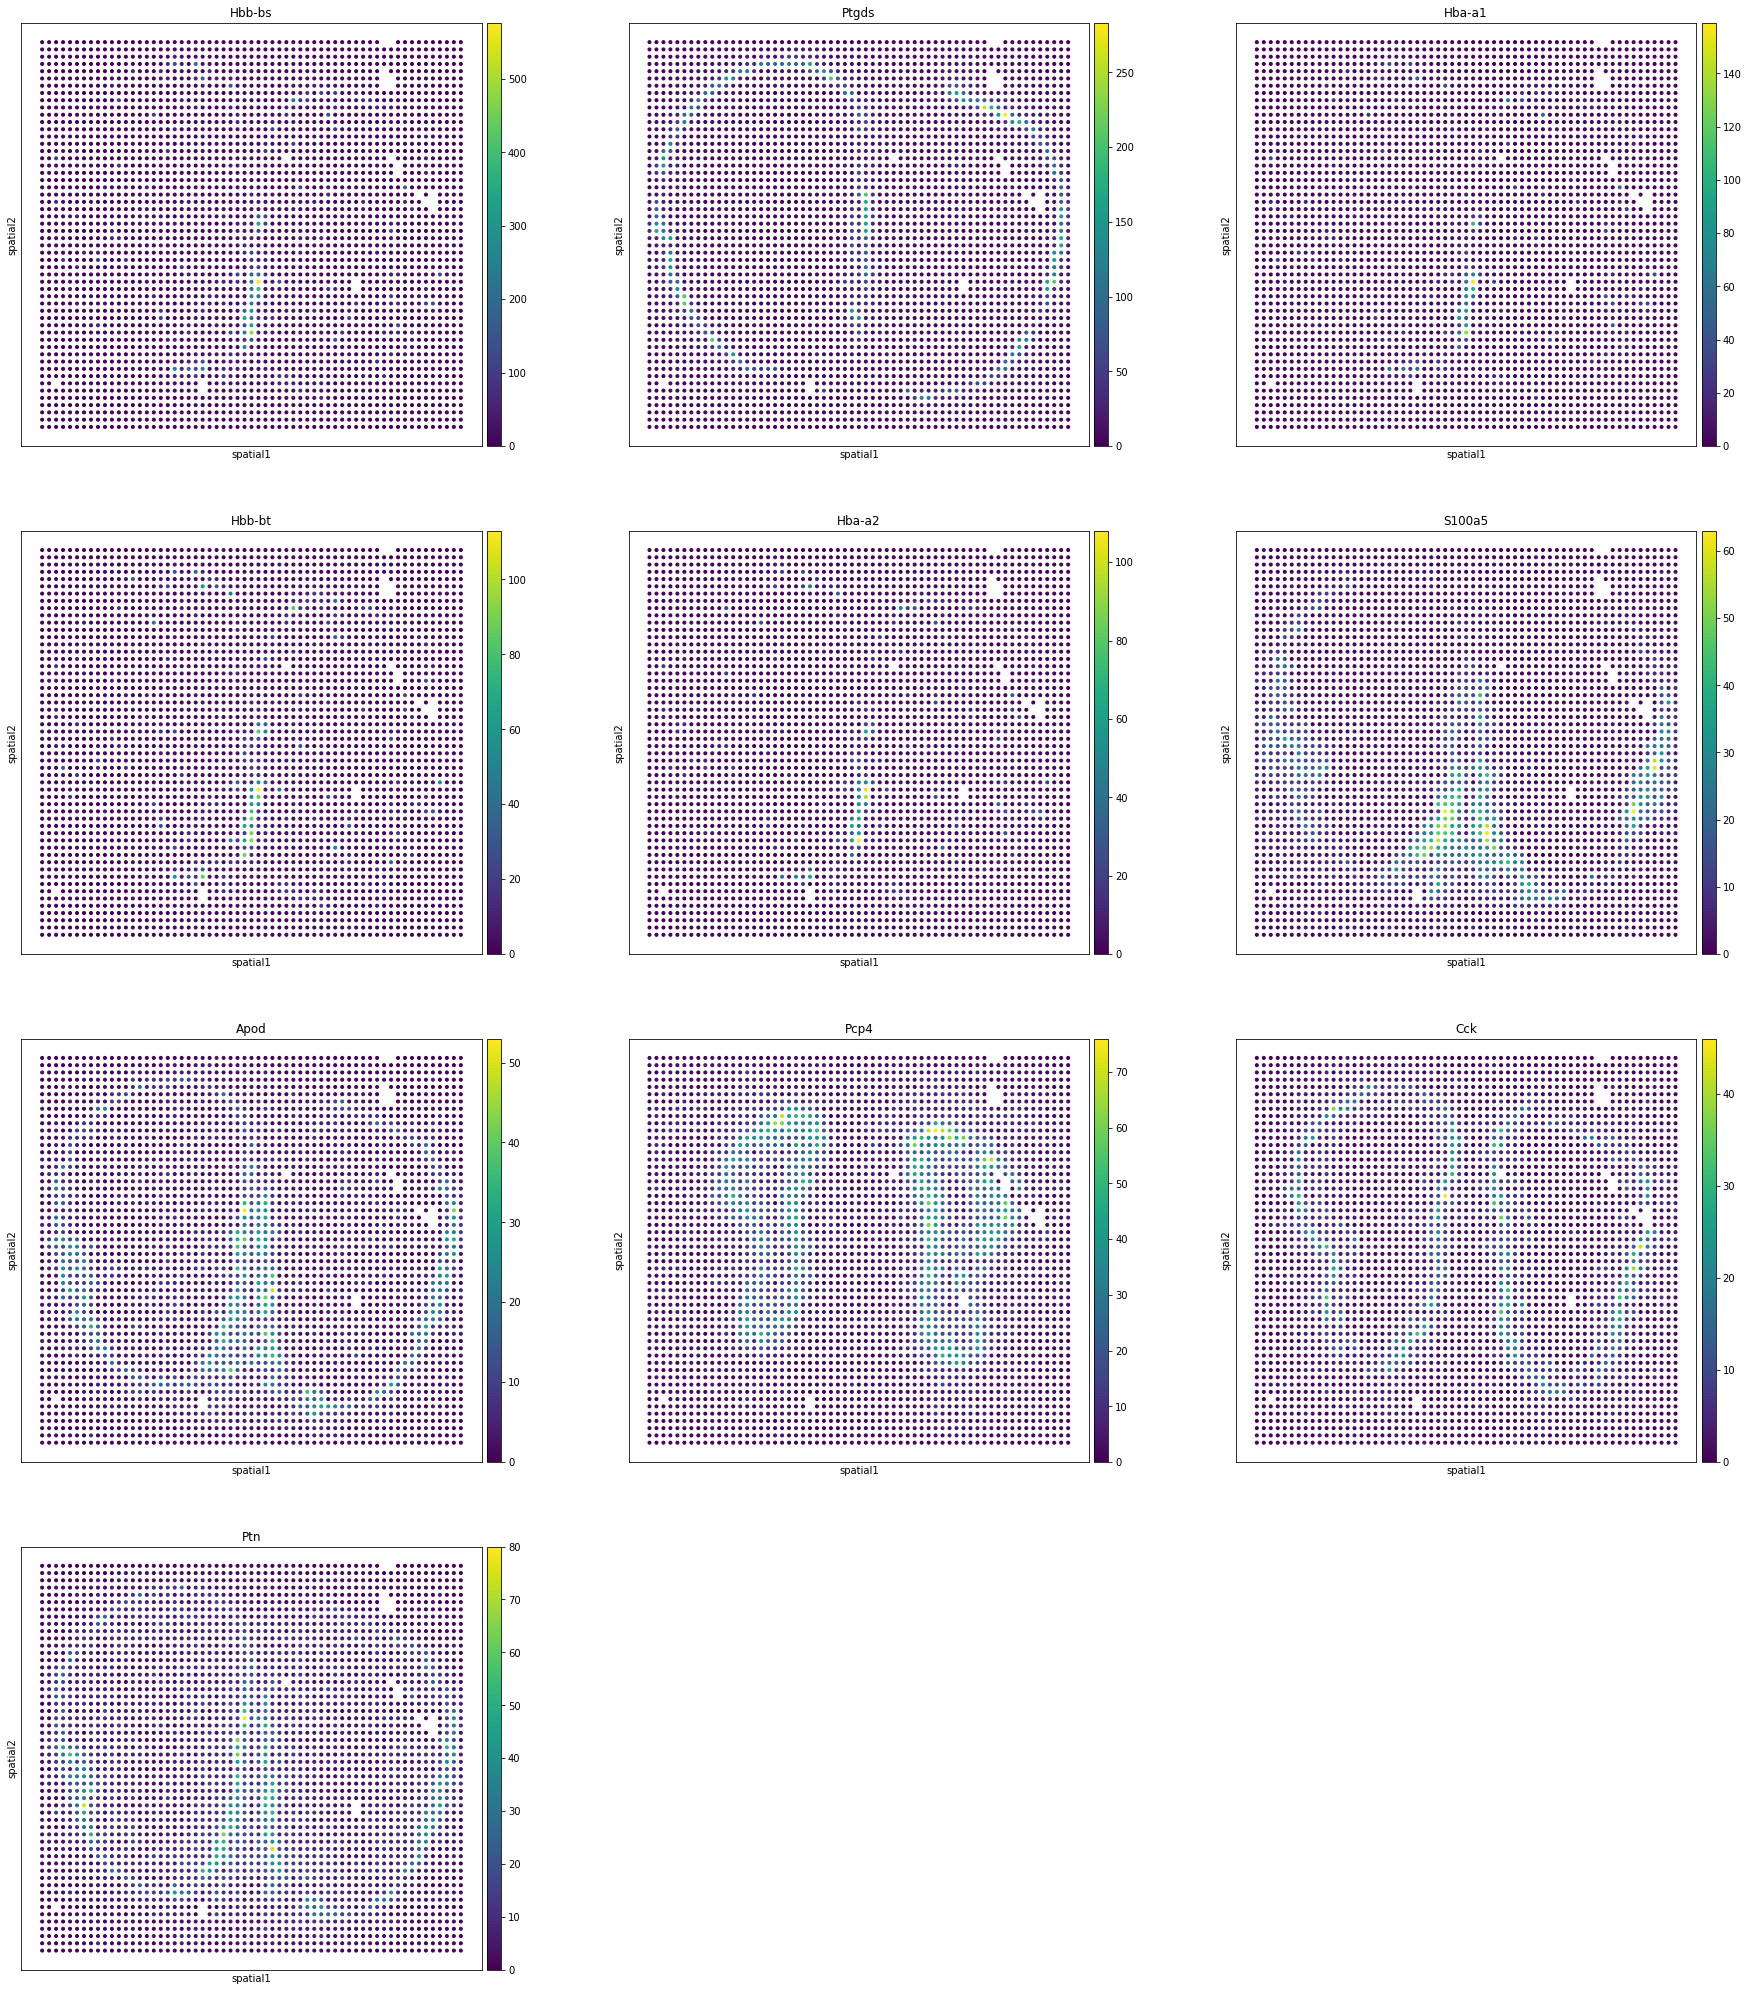

In [11]:
top_10_genes = pattern_genes.sort_values(by='E10', ascending=False).head(10).gene.values
st.plt.plot_scatter(andata, plot_key=top_10_genes, pos_key='spatial', ncols=3)